<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#LOAD-DATA" data-toc-modified-id="LOAD-DATA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>LOAD DATA</a></span></li><li><span><a href="#Test-data" data-toc-modified-id="Test-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test data</a></span></li><li><span><a href="#Data-Augmentations" data-toc-modified-id="Data-Augmentations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Augmentations</a></span></li><li><span><a href="#Datasets-and-dataloaders" data-toc-modified-id="Datasets-and-dataloaders-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Datasets and dataloaders</a></span></li><li><span><a href="#Train-valid-split" data-toc-modified-id="Train-valid-split-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train-valid split</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training-and-predict-functions" data-toc-modified-id="Training-and-predict-functions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Training and predict functions</a></span></li><li><span><a href="#Predictions" data-toc-modified-id="Predictions-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Predictions</a></span></li></ul></div>

# kaggle keypoints detection
- In this Notebook, we tried to add a mask vector in the dataset to handle the missing keypoints
- We tried albumentations to do data augmentations

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models
from torchvision.models.resnet import BasicBlock
from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## LOAD DATA

In [3]:
data_dir = Path('./data')
train_data = pd.read_csv(data_dir / 'training.csv')

## Test data

In [107]:
test_data = pd.read_csv('./data/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [4]:
def show_keypoints(image, keypoints):
    '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
    '''
      
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    '''
    Show images with keypoints in grids
    Args:
        df (DataFrame): data (M x N)
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if show image with keypoints
    '''
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

## Data Augmentations

! pip install -U git+https://github.com/albumentations-team/albumentations

In [6]:
import albumentations as albu
from urllib.request import urlopen
from matplotlib import pyplot as plt


from albumentations.pytorch import ToTensor,ToTensorV2

In [211]:
def plot_sample(image, keypoint, axis, title=None):
    axis.imshow(image)
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='.', s=20, color='red')
    axis.set_title(title)

def to_numpy(image):
    im_np = np.array([item for item in zip(image[0].flatten(),image[1].flatten(),image[2].flatten())])
    im_np = im_np.reshape(96,96,3).astype('uint8')
    return im_np

def create_transformer(transformations):
    return albu.Compose(transformations, p=1, 
                        keypoint_params=albu.KeypointParams(format='xy'))

## Datasets and dataloaders

In [499]:
class KeypointsDataset(Dataset):
    '''Keypoints Dataset'''
    
    def __init__(self, dataframe, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):

        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.
        

        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
            mask = (~np.isnan(keypoints)).astype(float)
            sample = {'image': image, 'keypoints': keypoints, 'mask': mask}
            
        else:
            sample = {'image': image}


        
        
        
        if self.transform:
            if self.train:
                keypoints_nonan = keypoints[~np.isnan(keypoints)]
                transformed = self.transform(image=image, keypoints=keypoints_nonan.reshape(-1,2))
                im = transformed['image']
                points = np.array(transformed['keypoints']).flatten()
                if len(points)==len(keypoints_nonan) and not((points<0).sum() or (points>IMG_SIZE).sum()):

                    sample['image'] = im
                    keypoints[np.argwhere(~np.isnan(keypoints)).flatten()] = np.array(points)
                    keypoints[np.argwhere(np.isnan(keypoints)).flatten()] = 0
                    sample['keypoints'] = torch.tensor(keypoints).float()
                else:
                    totensor = create_transformer([ToTensor(normalize={"mean":[0.485, 0.456, 0.406],
                                                                       "std":[0.229, 0.224, 0.225]})])
                    sample['image'] = totensor(image=image)['image']
                    keypoints[np.argwhere(np.isnan(keypoints)).flatten()] = 0
                    sample['keypoints'] = torch.tensor(keypoints).float()
            else:
                transformed = self.transform(image=image)
                im = transformed['image']
                sample['image'] = im
        return sample

In [433]:
# propare trainset
batch_size=64
tsfm = create_transformer([albu.Rotate(limit=30,p=0.75),
                           albu.RandomBrightnessContrast(p=0.75),
                           albu.RandomContrast(p=0.75),
                           albu.GaussNoise(p=0.75),
                           
                           #ToTensor(normalize={"mean":[0.485, 0.456, 0.406],"std":[0.229, 0.224, 0.225]})
                          ])
trainset = KeypointsDataset(df_train, transform=tsfm)


 ## Train-valid split

In [438]:
# train-valid split
indices = np.array(train_data.index)

np.random.shuffle(indices)

train_len = int(len(indices)*0.8)

train_idx = indices[:train_len]
valid_idx = indices[train_len:]

df_train = train_data.iloc[train_idx]
df_val = train_data.iloc[valid_idx]

In [439]:
# propare trainset
batch_size=64
aug = create_transformer([albu.Rotate(limit=30,p=0.75),
                           albu.RandomBrightnessContrast(p=0.75),
                           
                           ToTensor(normalize={"mean":[0.485, 0.456, 0.406],"std":[0.229, 0.224, 0.225]})
                          ])
trainset = KeypointsDataset(df_train, transform=aug)


In [440]:
# propare validset
batch_size=64
tsfm = create_transformer([ToTensor(normalize={"mean":[0.485, 0.456, 0.406],"std":[0.229, 0.224, 0.225]})
                          ])
validset = KeypointsDataset(df_val, transform=tsfm)


In [500]:
# propare testset
batch_size=64
tsfm = create_transformer([ToTensor(normalize={"mean":[0.485, 0.456, 0.406],"std":[0.229, 0.224, 0.225]})
                          ])
testset = KeypointsDataset(test_data, train=False, transform=tsfm)


In [501]:
# prepare dataloader
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(validset, batch_size=batch_size, num_workers=4)
test_dl = DataLoader(testset, batch_size=batch_size, num_workers=4)

## Model

In [443]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(4608), nn.Linear(4608, 30))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        
        
        return x

In [444]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [445]:
net = Net().to(device)

In [446]:
# prepare a toy dataloader
train_dl = DataLoader(trainset, batch_size=2, shuffle=True, num_workers=4)


In [447]:
batch = next(iter(train_dl))
x = batch['image']
y = batch['keypoints']
z = batch['mask']

In [448]:
y = y.to(device)
z = z.to(device)
y_hat = net(x.to(device))

In [459]:
F.mse_loss(y_hat, y)

tensor(2695.6416, device='cuda:0', grad_fn=<MseLossBackward>)

In [460]:
# loss per observation
loss = (z*F.mse_loss(y_hat, y, reduction="none")).mean()

In [461]:
loss.item()

2695.6415646405762

## Training and predict functions

In [462]:
def train(train_loader, valid_loader, model, lr, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''
    
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    model.train()

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            
            loss = F.mse_loss(output, batch['keypoints'].to(device), reduction="none")
            loss = batch['mask'].to(device)*loss
            loss = loss.mean()
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = F.mse_loss(output, batch['keypoints'].to(device), reduction="none")
            loss = batch['mask'].to(device)*loss
            loss = loss.mean()
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.dataset))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.dataset))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses  

    


In [467]:
batch_size = 64
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
valid_dl = DataLoader(validset, batch_size=batch_size, num_workers=4)
test_dl = DataLoader(testset, batch_size=batch_size, num_workers=4)

In [468]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)


In [469]:
model_path = Path('./models_dl2020')

In [470]:
train_losses, valid_losses = train(train_dl, valid_dl, model,
                                       lr=0.01, n_epochs=50, saved_model=model_path/'resnet34_mask.pt')


Epoch: 1 	Training Loss: 16.574609 	Validation Loss: 4.754867
Validation loss decreased (inf --> 4.754867).  Saving model ...
Epoch: 2 	Training Loss: 4.852050 	Validation Loss: 6.735689
Epoch: 3 	Training Loss: 5.796180 	Validation Loss: 3.041153
Validation loss decreased (4.754867 --> 3.041153).  Saving model ...
Epoch: 4 	Training Loss: 6.810970 	Validation Loss: 15.933210
Epoch: 5 	Training Loss: 5.903169 	Validation Loss: 2.975631
Validation loss decreased (3.041153 --> 2.975631).  Saving model ...
Epoch: 6 	Training Loss: 3.225760 	Validation Loss: 2.619653
Validation loss decreased (2.975631 --> 2.619653).  Saving model ...
Epoch: 7 	Training Loss: 2.842548 	Validation Loss: 3.916756
Epoch: 8 	Training Loss: 2.672504 	Validation Loss: 2.249745
Validation loss decreased (2.619653 --> 2.249745).  Saving model ...
Epoch: 9 	Training Loss: 2.587050 	Validation Loss: 2.224124
Validation loss decreased (2.249745 --> 2.224124).  Saving model ...
Epoch: 10 	Training Loss: 2.755179 	Vali

In [471]:
train_losses, valid_losses = train(train_dl, valid_dl, model,
                                       lr=0.001, n_epochs=50, saved_model=model_path/'resnet34_mask.pt')


Epoch: 1 	Training Loss: 1.683897 	Validation Loss: 1.918035
Validation loss decreased (inf --> 1.918035).  Saving model ...
Epoch: 2 	Training Loss: 1.637994 	Validation Loss: 1.760930
Validation loss decreased (1.918035 --> 1.760930).  Saving model ...
Epoch: 3 	Training Loss: 1.604819 	Validation Loss: 1.706940
Validation loss decreased (1.760930 --> 1.706940).  Saving model ...
Epoch: 4 	Training Loss: 1.592660 	Validation Loss: 1.645421
Validation loss decreased (1.706940 --> 1.645421).  Saving model ...
Epoch: 5 	Training Loss: 1.572291 	Validation Loss: 1.674142
Epoch: 6 	Training Loss: 1.583262 	Validation Loss: 1.729618
Epoch: 7 	Training Loss: 1.556501 	Validation Loss: 1.673574
Epoch: 8 	Training Loss: 1.537974 	Validation Loss: 1.551598
Validation loss decreased (1.645421 --> 1.551598).  Saving model ...
Epoch: 9 	Training Loss: 1.516602 	Validation Loss: 1.594463
Epoch: 10 	Training Loss: 1.535598 	Validation Loss: 1.553714
Epoch: 11 	Training Loss: 1.538169 	Validation Lo

In [472]:
train_losses, valid_losses = train(train_dl, valid_dl, model,
                                       lr=0.001, n_epochs=100, saved_model=model_path/'resnet34_mask.pt')


Epoch: 1 	Training Loss: 1.262696 	Validation Loss: 1.453768
Validation loss decreased (inf --> 1.453768).  Saving model ...
Epoch: 2 	Training Loss: 1.197220 	Validation Loss: 1.421263
Validation loss decreased (1.453768 --> 1.421263).  Saving model ...
Epoch: 3 	Training Loss: 1.281837 	Validation Loss: 1.448822
Epoch: 4 	Training Loss: 1.224216 	Validation Loss: 1.404600
Validation loss decreased (1.421263 --> 1.404600).  Saving model ...
Epoch: 5 	Training Loss: 1.209884 	Validation Loss: 1.480343
Epoch: 6 	Training Loss: 1.192880 	Validation Loss: 1.497431
Epoch: 7 	Training Loss: 1.158667 	Validation Loss: 1.533399
Epoch: 8 	Training Loss: 1.153943 	Validation Loss: 1.549524
Epoch: 9 	Training Loss: 1.173873 	Validation Loss: 1.452559
Epoch: 10 	Training Loss: 1.198935 	Validation Loss: 1.474930
Epoch: 11 	Training Loss: 1.197285 	Validation Loss: 1.496732
Epoch: 12 	Training Loss: 1.135204 	Validation Loss: 1.468675
Epoch: 13 	Training Loss: 1.219859 	Validation Loss: 1.522437
E

In [473]:
train_losses, valid_losses = train(train_dl, valid_dl, model,
                                       lr=0.0001, n_epochs=50, saved_model=model_path/'resnet34_mask.pt')


Epoch: 1 	Training Loss: 0.853219 	Validation Loss: 1.356903
Validation loss decreased (inf --> 1.356903).  Saving model ...
Epoch: 2 	Training Loss: 0.838561 	Validation Loss: 1.311472
Validation loss decreased (1.356903 --> 1.311472).  Saving model ...
Epoch: 3 	Training Loss: 0.839439 	Validation Loss: 1.345147
Epoch: 4 	Training Loss: 0.817293 	Validation Loss: 1.341231
Epoch: 5 	Training Loss: 0.821373 	Validation Loss: 1.347150
Epoch: 6 	Training Loss: 0.791518 	Validation Loss: 1.306872
Validation loss decreased (1.311472 --> 1.306872).  Saving model ...
Epoch: 7 	Training Loss: 0.833646 	Validation Loss: 1.310884
Epoch: 8 	Training Loss: 0.819101 	Validation Loss: 1.333163
Epoch: 9 	Training Loss: 0.825033 	Validation Loss: 1.322516
Epoch: 10 	Training Loss: 0.827068 	Validation Loss: 1.321301
Epoch: 11 	Training Loss: 0.788324 	Validation Loss: 1.346288
Epoch: 12 	Training Loss: 0.789266 	Validation Loss: 1.334418
Epoch: 13 	Training Loss: 0.783766 	Validation Loss: 1.329653
E

## Predictions

In [502]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

In [506]:
model.load_state_dict(torch.load(model_path/'resnet34_mask.pt'))

predictions = predict(test_dl, model)



In [507]:
predictions.shape

(1783, 30)

In [508]:
def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1

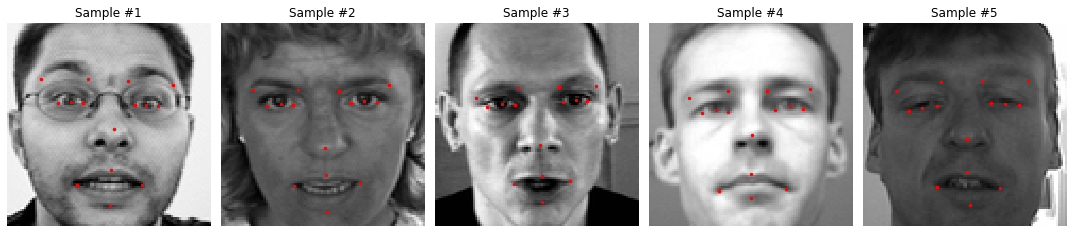

In [512]:
columns = df_train.columns[:-1]

view_pred_df(columns, test_data[:10], predictions)


In [515]:
def create_submission(predictions, pred_file='data/preds.csv', sub_file='data/submission.csv', columns=None):
    '''
    Create csv file for submission from predictions
    Args:
        predictions (array-like): prediction (no. fo images x 30 keypoints)
        pred_file (string): file path for prediction csv file
        sub_file (string): file path for submission csv file
        columns (dict): provided column names for submission file
    '''
    lookup = pd.read_csv('data/IdLookupTable.csv')
    if columns == None:
        columns = train_data.columns[:-1]
    preds = pd.DataFrame(predictions, 
                         index=np.arange(1, len(predictions)+1), 
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name] 
                 for image_id, feature_name 
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location < IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)

In [516]:
create_submission(predictions, 
                  pred_file='data/resnet34_mask_preds.csv', 
                  sub_file='data/resnet34_mask_submission.csv')

In [517]:
# Comment out to submit to Kaggle: private 1.68023 public 1.87465
import os
os.environ['KAGGLE_USERNAME'] = ""
os.environ['KAGGLE_KEY'] = ""


!kaggle competitions submit -c facial-keypoints-detection -f data/resnet34_mask_submission.csv -m "resnet34_mask"

100%|█████████████████████████████████████████| 629k/629k [00:03<00:00, 165kB/s]
Successfully submitted to Facial Keypoints Detection